In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import torch
from sklearn import metrics
import pickle
from tqdm import tqdm
import itertools
import gffutils
import argparse
import sqlite3
import json
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]


def quantile_norm(pred1, pred2):
    if pred1.shape[0] - pred1.shape[1]:
        raise ValueError(
            'Matrix 1 is not square ({}, {})'.format(pred1.shape[0], pred1.shape[1])
        )
    if pred2.shape[0] - pred2.shape[1]:
        raise ValueError(
            'Matrix 2 is not square ({}, {})'.format(pred2.shape[0], pred2.shape[1])
        )
    if pred1.shape[0] - pred2.shape[0]:
        raise ValueError(
            'Matrix dimension mismatch ({} vs {})'.format(pred1.shape[0], pred2.shape[0])
        )
    l = pred1.shape[0]
    pred1_diag = np.array([
        np.pad(np.diagonal(pred1, offset=i), (0, i), 'constant') for i in range(200)
    ]).T
    pred2_diag = np.array([
        np.pad(np.diagonal(pred2, offset=i), (0, i), 'constant') for i in range(200)
    ]).T
    pred = np.column_stack((pred1_diag.ravel(), pred2_diag.ravel()))
    df, df_sort = pd.DataFrame(pred), pd.DataFrame(np.sort(pred, axis=0))
    df_mean = df_sort.mean(axis=1)
    df_mean.index += 1
    df_qn = df.rank(method='min').stack().astype(int).map(df_mean).unstack()
    pred1_stripe, pred2_stripe = df_qn[0].values.reshape(-1, 200), df_qn[1].values.reshape(-1, 200)

    pred1_qn, pred2_qn = np.zeros_like(pred1), np.zeros_like(pred2)
    for i in range(200):
        idx = np.arange(l - i, dtype=int)
        pred1_qn[idx, idx+i] = pred1_qn[idx+i, idx] = pred1_stripe[:l-i, i]
        pred2_qn[idx, idx+i] = pred2_qn[idx+i, idx] = pred2_stripe[:l-i, i]
    
    return pred1_qn, pred2_qn


def quantile_norm(preds):
    



def topdom(pred_mat, window_size=10, cutoff=0):
    if pred_mat.shape[0]-pred_mat.shape[1]:
        raise ValueError(
            'Dimension mismatch ({}, {})'.format(pred_mat.shape[0], pred_mat.shape[1])
        )
    pad_mat = np.pad(pred_mat, window_size, mode='constant', constant_values=np.nan)
    dim = pad_mat.shape[0]
    signal = np.array([
        np.nanmean(pad_mat[i-window_size:i, i:i+window_size]) for i in range(dim)
    ][window_size+1: -window_size])
    if cutoff is not None:
        signal[signal<cutoff] = cutoff

    return signal


def interpolate(signal, bin_size=10000, pattern='smooth'):
    if pattern is None: return signal
    if pattern not in ['smooth', 'zigzag']:
        raise ValueError(
            'Bad parameter, expecting \'smooth\' or \'zigzag\' but got \'{}\''.format(pattern)
        )
    if pattern=='smooth':
        l = len(signal) * bin_size
        sparse, compact = np.linspace(0, l, len(signal)), np.linspace(0, l, l)
        interp_signal = np.interp(compact, sparse, signal)
    else:
        interp_signal = np.tile(signal, (bin_size, 1)).flatten('F')
    
    return interp_signal


def sim_pearson(signal1, signal2, window_size=10):
    l = len(signal1)
    score = np.array([
        scipy.stats.pearsonr(
            signal1[i:i+window_size], signal2[i:i+window_size]
        )[0] for i in range(l-window_size)
    ])
    score[score != score] = 1

    return score


def sim_difference(signal1, signal2):
    score = signal1 - signal2
    score[score != score] = 0

    return score


def similarity(signal1, signal2, kernel='diff', window_size=10):
    if len(signal1)-len(signal2):
        raise ValueError(
            'Different signal1.length ({}) and signal2.length ({})'.format(len(signal1), len(signal2))
        )
    if kernel == 'diff':
        score = sim_difference(signal1, signal2)
    elif kernel == 'pearson':
        score = sim_pearson(signal1, signal2, window_size=window_size)
    
    return score


def threshold(score, cutoff=0.7, kernel='diff', margin=1000):
    if kernel == 'diff':
        indices = np.argwhere(np.abs(score)>=cutoff).flatten()
    elif kernel == 'pearson':
        indices = np.argwhere(score <= cutoff).flatten()
    if len(indices) == 0:
        raise ValueError(
            'No valid result above threshold. Please consider expanding your search by changing the filters'
        )
    starts, ends = [], []
    s, e = 0, 0
    for i in tqdm(indices, desc='selecting significant regions', position=0, leave=True):
        if not s and not e: s, e = i, i
        else:
            if i - e <= margin: e = i
            else:
                starts.append(s)
                ends.append(e)
                s, e = i, i
    if e != ends[-1]:
        starts.append(s)
        ends.append(e)
    regions = pd.DataFrame({
        'start': np.array(starts) - margin,
        'end': np.array(ends) + margin
    })
    return regions


pred_dir = '/data/leslie/suny4/predictions/chromafold/'
chrom = 8

In [13]:
%%time


ct1, ct2, ct3 = 'darko_wt_cb', 'darko_arid1ahet_cb', 'darko_ctcfhet_cb'
pred1 = load_pred(pred_dir, ct1, chrom, avg_stripe=True)
pred2 = load_pred(pred_dir, ct2, chrom, avg_stripe=True)
pred3 = load_pred(pred_dir, ct3, chrom, avg_stripe=True)

CPU times: user 3.11 s, sys: 1.48 s, total: 4.59 s
Wall time: 4.74 s


In [14]:
%%time

td1 = topdom(pred1, window_size=50, cutoff=None)
td2 = topdom(pred2, window_size=50, cutoff=None)
td3 = topdom(pred3, window_size=50, cutoff=None)

CPU times: user 1 s, sys: 282 ms, total: 1.28 s
Wall time: 1.29 s


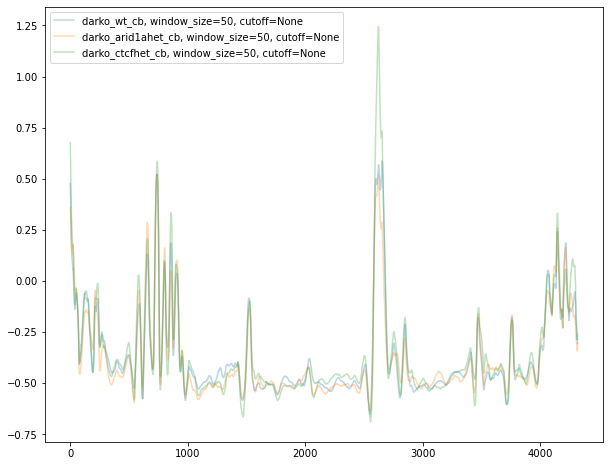

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(td1[5000:10000], alpha=0.3, label='{}, window_size=50, cutoff=None'.format(ct1))
plt.plot(td2[5000:10000], alpha=0.3, label='{}, window_size=50, cutoff=None'.format(ct2))
plt.plot(td3[5000:10000], alpha=0.3, label='{}, window_size=50, cutoff=None'.format(ct3))
plt.legend()
plt.show()

In [10]:
%%time

pred1_norm, pred2_norm = quantile_norm(pred1, pred2)
pred3_norm, pred4_norm = quantile_norm(pred3, pred4)

CPU times: user 12.4 s, sys: 2.5 s, total: 14.9 s
Wall time: 14.9 s


In [11]:
%%time

td1_norm_10, td2_norm_10 = topdom(pred1_norm, window_size=10, cutoff=None), topdom(pred2_norm, window_size=10, cutoff=None)
td3_norm_10, td4_norm_10 = topdom(pred3_norm, window_size=10, cutoff=None), topdom(pred4_norm, window_size=10, cutoff=None)

CPU times: user 4.67 s, sys: 2.49 s, total: 7.17 s
Wall time: 7.18 s


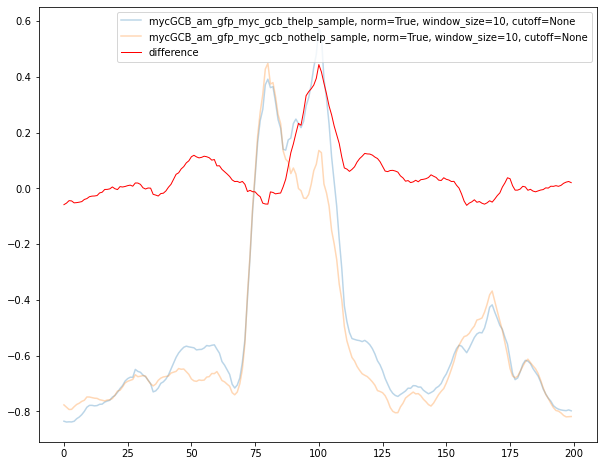

In [32]:
plt.figure(figsize=(10, 8))
plt.plot(td1_norm_10[2300:2500], alpha=0.3, label='{}, norm=True, window_size=10, cutoff=None'.format(ct1))
plt.plot(td2_norm_10[2300:2500], alpha=0.3, label='{}, norm=True, window_size=10, cutoff=None'.format(ct2))
plt.plot((td1_norm_10 - td2_norm_10)[2300:2500], label='difference', color='red', linewidth=1)
plt.legend()
plt.show()

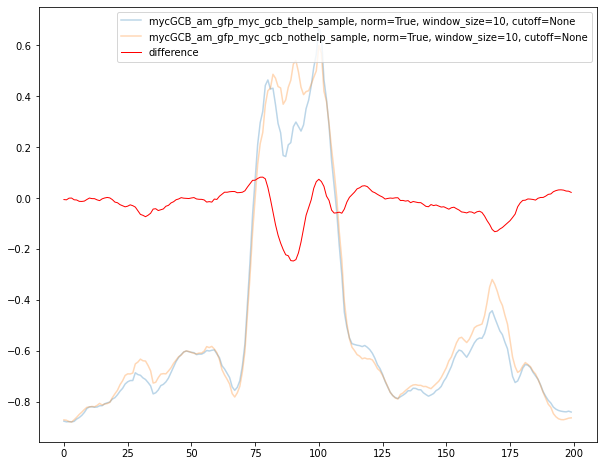

In [33]:
plt.figure(figsize=(10, 8))
plt.plot(td3_norm_10[2300:2500], alpha=0.3, label='{}, norm=True, window_size=10, cutoff=None'.format(ct1))
plt.plot(td4_norm_10[2300:2500], alpha=0.3, label='{}, norm=True, window_size=10, cutoff=None'.format(ct2))
plt.plot((td3_norm_10 - td4_norm_10)[2300:2500], label='difference', color='red', linewidth=1)
plt.legend()
plt.show()